Regarding exploratory data analysis (EDA), it is possible that we may not possess sufficient familiarity with the domain of application to determine which questions are pertinent to ask when examining such a dataset.

# EDA


Exploratory Data Analysis (EDA) is a crucial step in any data analysis process, including Natural Language Processing (NLP). The purpose of EDA in NLP is to gain insights and understanding of the textual data. Here to find if there are different type of cases

In [2]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Librairies

In [3]:
import os
import json
import string
from pathlib import Path
from typing import Union
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import notebook
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data Extraction

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# Set the directory where the corpus files are located
directory = 'drive/MyDrive/Colab_Notebooks/fulltext'

data = dict()

file_list = os.listdir(directory)

for filename in notebook.tqdm(file_list):
    with open(directory + "/" + filename, 'r') as f:
        raw_data = f.read()
    
    # Parse the XML data using BeautifulSoup
    bs_data = BeautifulSoup(raw_data,'xml')
    
    texts = list()
    
    if bs_data.findChild('sentences') == None:
        # If there are no <sentences>, extract the text from each <text> tag
        for tag in bs_data.find_all('text'):
            texts.append(tag)
    else:
        # If there are <sentences>, extract the text from each <sentences> tag
        for tag in bs_data.find_all('sentences'):
            texts.append(tag)

  data[filename] = texts

  0%|          | 0/3890 [00:00<?, ?it/s]

### Preprocessing

In [8]:
class TextPreprocessor:
    def __init__(self):
        """Initiates TextPreprocessor class with nltk resources."""
        self.stopwords = stopwords.words('english')
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

        
    def check_null_values(self, text: str) -> bool:
        """
        Returns True if text is null or empty, False otherwise.
        """
        if text == "":
            return None
        else:
            return text

    def remove_urls_html_tags(self, text: str) -> str:
        """
        Removes URLs and HTML tags from the text.
        """
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove HTML tags
        text = re.sub(r'<[^>]*>', '', text)
        return text

    def lowercase(self, text: str) -> str:
        """
        Converts the text to lowercase.
        """
        return text.lower()

    def remove_digits(self, text: str, keep_digits=False) -> str:
        """
        Removes digits and words containing digits from the text.

        If keep_digits is True, only words containing digits will be removed,
        while individual digits will be kept in the text.
        """
        if keep_digits:
            # Remove only words containing digits
            text = re.sub(r'\b\d+\b', '', text)
        else:
            # Remove all digits
            text = text.translate(text.maketrans('', '', string.digits))
        return text

    def remove_extra_spaces(self, text: str) -> str:
        """
        Removes extra spaces from the text.
        """
        return re.sub(r'\s+', ' ', text).strip()

    def tokenize(self, text: str) -> list:
        """
        Splits the text into tokens (words).
        """
        return text.split(" ")

    def remove_stopwords(self, tokens: list) -> list:
        """
        Removes stopwords from the tokens.
        """
        return [token for token in tokens if token not in self.stopwords]                  

    def stem(self, tokens: list) -> list:
        """
        Stems the tokens using Porter stemmer.
        """
        return [self.stemmer.stem(token) for token in tokens]

    def lemmatize(self, tokens: list) -> list:
        """
        Lemmatizes the tokens using WordNet lemmatizer.
        """
        return [self.lemmatizer.lemmatize(token) for token in tokens]

    def remove_short_tokens(self, tokens: list) -> list:
        """
        Removes tokens with length <= 2.
        """
        return [token for token in tokens if len(token) > 2]

    def count_vectorize(self, tokens: list) -> list:
        """
        Transforms tokens into an array of their occurrences in the input.
        """
        vectorizer = CountVectorizer()
        vectors = vectorizer.fit_transform(tokens)
        return vectors.toarray()

    def one_hot_encode(self, tokens: list) -> list:
        """
        One-hot encodes the tokens.
        """
        encoder = OneHotEncoder()
        one_hot = encoder.fit_transform(tokens)
        return one_hot.toarray()                        

    def n_grams(self, tokens: list, n: int) -> list:
        """Returns a list of n-grams for the tokens"""
        n_grams = []
        for i in range(len(tokens)-n+1):
            n_grams.append(tokens[i:i+n])
        return n_grams

In [9]:
processing = TextPreprocessor()
def preprocess(text):
    doc = re.sub(r'\n', ' ', text) #we remove \n
    doc = re.sub(r"\'", ' ', doc)
    doc = processing.remove_urls_html_tags(doc)
    doc = processing.lowercase(doc)
    doc = processing.tokenize(doc)
    doc = processing.remove_stopwords(doc)
    doc = processing.remove_short_tokens(doc)
    return " ".join(doc)

In [10]:
documents = [preprocess(data[key][0].text) for key in data.keys()]

In [ ]:
len(documents)

3890

#### Sample of a preprocess document

In [ ]:
documents[10]

'introduction applicant (dr thoo) applies administrative decisions (judicial review) act 1977 (cth) 39b(1a) judiciary act 1903 (cth) review series decisions culminated decision first respondents (committee), june 2007 thoo, general medical practitioner, engaged inappropriate practice connection providing certain services. result orders previously made trial separate questions, issue court reasons relate thoo challenge administrative law grounds committee decision. accordingly, respondents, committee appeared hearing. thoo relies two grounds. first, contends committee inquired into, made finding respect of, services lying outside respect law authorised make inquiry decision. second ground relates hearing committee february 2006. thoo contends day committee denied procedural fairness, particular, refusing request adjournment hearing. associated refusal, thoo complains committee received submissions and/or advice committee legal advisors course hearing absence thoo; committee continued he

## Explanatory Data Analysis

In [ ]:
class TextAnalyzer:
    def __init__(self, text):
        self.text = text
        self.sentences = sent_tokenize(text)
        self.words = word_tokenize(text)
        self.unique_words = set(self.words)
        # self.stopwords = set(stopwords.words('english'))
        self.punctuations = set(string.punctuation)
        self.hashtags = set(re.findall(r'#\w+', text))
        self.mentions = set(re.findall(r'@\w+', text))
    
    def num_characters(self):
        return len(self.text)
    
    def num_words(self):
        return len(self.words)
    
    def num_capital_characters(self):
        return sum(1 for c in self.text if c.isupper())
    
    def num_capital_words(self):
        return sum(1 for w in self.words if w.isupper())
    
    def num_punctuations(self):
        return sum(1 for c in self.text if c in self.punctuations)
    
    def num_words_in_quotes(self):
        return sum(1 for w in self.words if w[0] in ['\'', '"'])
    
    def num_sentences(self):
        return len(self.sentences)
    
    def num_unique_words(self):
        return len(self.unique_words)
    
    def num_hashtags(self):
        return len(self.hashtags)
    
    def num_mentions(self):
        return len(self.mentions)
    
    def unique_words_vs_word_count(self):
        return len(self.unique_words) / len(self.words)
    
    def stopwords_count_vs_word_count(self):
        return self.num_stopwords() / len(self.words)

In [ ]:
nb_words = dict()
nb_kapital_caracters = dict()
n_unique_words = dict()
n_sentences = dict()
# documents = [clean_data(data[key][0].text) for key in data.keys()]
n_word = 0
n_k_caracter = 0
n_sentence = 0
n_unique_word = 0
for document in notebook.tqdm(documents):
    n_word += TextAnalyzer(document).num_words()
    n_sentence += TextAnalyzer(document).num_sentences()
    n_unique_word += TextAnalyzer(document).num_unique_words()
    n_k_caracter += TextAnalyzer(document).num_characters()

  0%|          | 0/3890 [00:00<?, ?it/s]

In [ ]:
tuples_list = []
unique_labels = ["results"]
for label in unique_labels:
    tuples_list.append((label, n_k_caracter, n_word, n_unique_word, n_sentence))

print(tabulate(tuples_list, headers=['number of Capital Chars', 'number of words', 'number of unique words', 'number of sentence'], tablefmt="fancy_grid"))

╒═════════╤═══════════════════════════╤═══════════════════╤══════════════════════════╤══════════════════════╕
│         │   number of Capital Chars │   number of words │   number of unique words │   number of sentence │
╞═════════╪═══════════════════════════╪═══════════════════╪══════════════════════════╪══════════════════════╡
│ results │                 101015499 │          15580905 │                  3660420 │               725825 │
╘═════════╧═══════════════════════════╧═══════════════════╧══════════════════════════╧══════════════════════╛


We have a corpus of 725K sentences and 15.5M of words

### Analyzing text statistics

In [ ]:
df = pd.DataFrame(documents)
df

,0
0,appeal raises two issues appellant must succee...
1,matter listed judgment afternoon. appeal heard...
2,"april 2008 plaintiff (""nationwide"") filed orig..."
3,february 2008 application order review notice ...
4,appeal order made federal magistrate. november...
...,...
3885,applicant registered proprietor australian tra...
3886,application extension time file serve notice a...
3887,"two notices motion today. first, first, second..."
3888,introduction marilyn mee ching pelka receipt c...


In [ ]:
df[0].str.len().describe()

count    3.890000e+03
mean     2.596799e+04
std      4.782170e+04
min      5.460000e+02
25%      8.108000e+03
50%      1.557500e+04
75%      2.925275e+04
max      1.808317e+06
Name: 0, dtype: float64

A document has in mean 2.5k characters

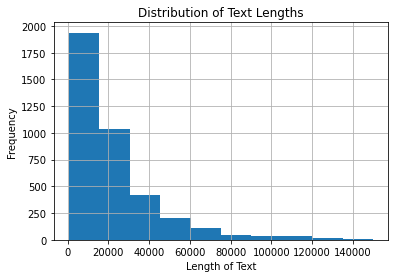

In [ ]:
len_char = df[0].str.len().copy()
len_char[len_char<150000].hist()

plt.title("Distribution of Text Lengths")
plt.xlabel("Length of Text")
plt.ylabel("Frequency")
plt.show()

The majority of cases got less thant 20K characters

## Frequences

As part of our Exploratory Data Analysis (EDA) in Natural Language Processing (NLP) projects, we will investigate N-grams, including unigrams, bigrams, and trigrams.

Unigrams, also known as 1-grams, are individual words or tokens in a text corpus. They are the simplest form of N-grams and represent the basic building blocks of the text data.

Bigrams, also known as 2-grams, are sequences of two consecutive words in a text corpus. They capture some of the basic syntactic and semantic relationships between adjacent words in the text.

Trigrams, also known as 3-grams, are sequences of three consecutive words in a text corpus. They provide more context and specificity than bigrams and can capture more complex syntactic and semantic relationships between words in the text.

Exploring N-grams during EDA can provide valuable insights into the vocabulary, language usage, and context of the text data, which can inform subsequent steps in the NLP pipeline, such as feature engineering, model design, and task-specific customization.

Here are some reasons why you should consider exploring N-grams during EDA:

**Vocabulary and Term Frequency**: N-grams can reveal the most frequent and relevant terms in the text data, which can help you understand the vocabulary and language usage of the corpus.

**Feature Engineering**: N-grams can be used as features in NLP models, such as bag-of-words or n-gram language models. Exploring N-grams during EDA can help you identify relevant features and optimize your model design.

**Entity Recognition**: N-grams can be used to identify named entities in text data, which is a crucial task in many NLP applications. By exploring the most common N-grams in the corpus, you can gain insights into the entity types and frequencies present in the data.

**Classification and Clustering**: N-grams can be used to classify or cluster text data based on similarity or dissimilarity. Exploring N-grams during EDA can help you identify patterns and relationships in the data that can inform your clustering or classification approach.

**Domain-Specific Language**: N-grams can reveal domain-specific language and jargon, which is important in specialized fields such as law, medicine, or finance. By exploring N-grams during EDA, you can gain insights into the specific terminology and language used in the corpus, which can inform subsequent steps in the NLP pipeline.

In [ ]:
#@title Most Common
def get_most_common_ngrams(texts: list, ngram_min: int, ngram_sup: int) -> pd.DataFrame:
    """
    Returns the most common n-grams in a list of texts.

    Args:
    - texts (list): A list of strings to process.
    - ngram_min (int): The minimum n-gram size.
    - ngram_sup (int): The maximum n-gram size.

    Returns:
    - A pandas DataFrame with two columns: 'words' and 'count', sorted by count in descending order.
    """

    # Create a CountVectorizer object with the desired n-gram range and stop words
    vectorizer = CountVectorizer(ngram_range=(ngram_min, ngram_sup), stop_words='english')
    # Fit and transform the input texts
    X = vectorizer.fit_transform(texts)

    # Get the n-gram names and their counts
    ngrams = vectorizer.get_feature_names()
    counts = X.toarray().sum(axis=0)

    res = [[count, ngram] for ngram, count in zip(ngrams, counts) if count > 9]

    res.sort(reverse=True)

    df_count = pd.DataFrame(res, columns=['count', 'words'])
    return df_count

In [ ]:
#@title IDF
from sklearn.feature_extraction.text import TfidfVectorizer

def idf_sklearn(word, documents, n_low, n_high):
    vectorizer = TfidfVectorizer(use_idf=True,  ngram_range=(n_low, n_high))
    tfidf_matrix = vectorizer.fit_transform(documents)
    idf = vectorizer.idf_[vectorizer.vocabulary_[word]]
    return idf


IDF stands for Inverse Document Frequency, which is a statistical measure used to evaluate the importance of a term in a collection of documents. The IDF value of a term increases proportionally to the number of documents in which the term appears, but decreases inversely with the frequency of the term in the corpus. The purpose of IDF is to identify terms that are distinctive or unique to a particular document, rather than those that are common across the entire corpus. In natural language processing (NLP) and information retrieval (IR), IDF is often used in conjunction with term frequency (TF) to calculate the TF-IDF weight of a term, which is a widely used feature in many text-based applications, including search engines, recommender systems, and content-based filtering. The IDF measure is a critical component of the TF-IDF approach, as it allows for the identification of terms that are most relevant to a particular document or query, while minimizing the impact of terms that are common or uninformative.

$$\mathrm{idf}(t, D) = \log \frac{N}{|\{d \in D : t \in d\}|}$$

In this formula, t is the term for which we're calculating IDF, D is the set of documents, N is the total number of documents in the corpus, and $|\{d \in D : t \in d\}|$ is the number of documents in which the term t appears. The log function is the natural logarithm.



### Unigrams

In [ ]:
res = get_most_common_ngrams(documents, 1, 1)
print("-------------------- Most Common ---------------")
print(res.head(50))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


-------------------- Most Common ---------------
    count          words
0   76455      applicant
1   76333            act
2   75287          court
3   64233       tribunal
4   59901       evidence
5   48169    application
6   45219     respondent
7   44698           said
8   43353       decision
9   40835           case
10  38922          claim
11  37200      appellant
12  36034           time
13  35870          order
14  30023           2006
15  28393      australia
16  27707      agreement
17  27694         person
18  27272       relevant
19  27043        reasons
20  26543       relation
21  25260          costs
22  24953         notice
23  24570            pty
24  24411           2007
25  24217    information
26  23715        company
27  23564         appeal
28  23246    proceedings
29  22273        federal
30  22244        hearing
31  22209           2005
32  22189        conduct
33  22061         matter
34  21902        respect
35  21594    respondents
36  21505       question
3

Based on our analysis, we have observed that the most frequently occurring words in the text corpus are related to legal terminology and lexicon, which is consistent with the domain of the text data. This finding has significant implications for the design and implementation of NLP models and algorithms, including feature selection, data preprocessing, and model training. By taking into account the domain-specific vocabulary and context, we can improve the accuracy and relevance of the NLP system for legal applications.

In [ ]:
#@title IDF
for word in res['words'].head(10).values:
  print(f'{word} : {idf_sklearn(word, documents, 1, 1)}')

applicant : 1.1541935146348294
act : 1.067232113906486
court : 1.0268280186785845
tribunal : 1.8737739522629302
evidence : 1.1689951743873401
application : 1.0592923049132277
respondent : 1.152994833040899
said : 1.161718004613445
decision : 1.2415593226981425
case : 1.0928459863504005


### Bigrams

In [ ]:
res = get_most_common_ngrams(documents, 2, 2)
print("-------------------- Most Common ---------------")
print(res.head(50))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


-------------------- Most Common ---------------
    count                      words
0    7882              federal court
1    7523         federal magistrate
2    7497               native title
3    6299       minister immigration
4    5755            statement claim
5    5408           reasons judgment
6    4510  immigration multicultural
7    4423          magistrates court
8    4268                 high court
9    4249          second respondent
10   4234        federal magistrates
11   4153               present case
12   3977              date judgment
13   3935                  true copy
14   3916         honourable justice
15   3914        numbered paragraphs
16   3914               copy reasons
17   3902             privacy policy
18   3890            policy feedback
19   3890         policy disclaimers
20   3890               feedback url
21   3890        disclaimers privacy
22   3890           copyright policy
23   3890          certify preceding
24   3890          austlii

We observed that the most common bigrams in the text corpus can be used to differentiate between different types of legal cases, such as intellectual property and immigration.

In [ ]:
#@title IDF
for word in res['words'].head(10).values:
  print(f'{word} : {idf_sklearn(word, documents, 2, 2)}')

federal court : 1.5634137905053174
federal magistrate : 2.5025365644221185
native title : 4.361146694546124
minister immigration : 2.1630994104584413
statement claim : 2.5318298130116057
reasons judgment : 1.0020581432528863
immigration multicultural : 2.2985122711826698
magistrates court : 2.328136988967594
high court : 2.054127004484213
second respondent : 2.447497407709032


## Trigrams

In [ ]:
res = get_most_common_ngrams(documents, 3, 3)
print("-------------------- Most Common ---------------")
print(res.head(50))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


-------------------- Most Common ---------------
    count                                 words
0    4258    minister immigration multicultural
1    4096             federal magistrates court
2    3890               privacy policy feedback
3    3890                   policy feedback url
4    3890            policy disclaimers privacy
5    3890            disclaimers privacy policy
6    3890          copyright policy disclaimers
7    3890                 copy reasons judgment
8    3890              austlii copyright policy
9    3884                     true copy reasons
10   3878           reasons judgment honourable
11   3871                  paragraphs true copy
12   3870           judgment honourable justice
13   3869              numbered paragraphs true
14   3245                       new south wales
15   2636      multicultural indigenous affairs
16   2636  immigration multicultural indigenous
17   2277                   trade practices act
18   2158               federal court a

The type of cases seems more visible here "minister immigration multicultural", "title rights interests"

In [ ]:
#@title IDF
for word in res['words'].head(10).values:
  print(f'{word} : {idf_sklearn(word, documents, 3, 3)}')

minister immigration multicultural : 2.338863566706237
federal magistrates court : 2.395330178374008
privacy policy feedback : 1.0
policy feedback url : 1.0
policy disclaimers privacy : 1.0
disclaimers privacy policy : 1.0
copyright policy disclaimers : 1.0
copy reasons judgment : 1.0028310403672345
austlii copyright policy : 1.0
true copy reasons : 1.0020581432528863


## Sentiments Analysis

Sentiment analysis, also known as opinion mining, is a natural language processing (NLP) technique that involves analyzing text data to determine the sentiment or emotion expressed in the text. The goal of sentiment analysis is to classify the text as positive, negative, or neutral based on the emotions and opinions expressed.

This can help you identify whether the tone of the cases is generally positive or negative

In [ ]:
from textblob import TextBlob

def polarity(text):
    return TextBlob(text).sentiment.polarity

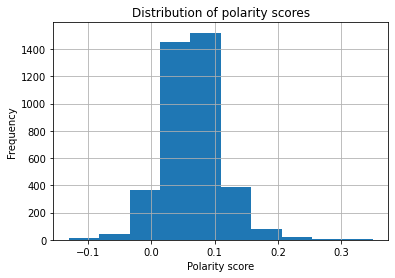

In [ ]:
df = pd.DataFrame(documents)
df['polarity_score']=df[0].apply(lambda x : polarity(x))
df['polarity_score'].hist()

plt.title("Distribution of polarity scores")
plt.xlabel("Polarity score")
plt.ylabel("Frequency")
plt.show()

The tone of the cases is mostly positive. A corpus of legal cases with mostly positive polarities can indicate a few things:

- Legal cases tend to focus on resolving disputes and conflicts, so it is possible that the positive polarities reflect successful outcomes in these cases. For example, a positive polarity may indicate that a court ruled in favor of a plaintiff or that a settlement was reached that satisfied both parties.

- It is also possible that the positive polarities reflect the language and tone of legal documents, which may tend to be more formal and neutral in their language. For example, legal documents may use words that have positive connotations (such as "justice" or "fairness") in a neutral or factual context, which could result in a positive polarity even if the underlying sentiment is not necessarily positive.

- Another possibility is that the positive polarities reflect the biases and perspectives of the legal system itself. For example, some legal cases may be more likely to result in positive outcomes for certain groups of people (such as wealthy or privileged individuals), which could result in a corpus with mostly positive polarities.

## WordCloud

A wordcloud is a visual representation of text data in which the most frequent words appear larger than less frequent words. It is a powerful tool for quickly identifying the most important and relevant words in a text corpus. In Python, wordclouds can be created using various libraries, such as wordcloud, matplotlib, and numpy. These libraries provide a simple and efficient way to generate customizable and visually appealing wordclouds from textual data. Wordclouds can be used in a variety of applications, such as data visualization, text mining, and natural language processing, to help extract insights and make data-driven decisions.

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(corpus):
    """
    Plots a word cloud of the given corpus.
    """
    # Combine all the documents into a single string
    text = ' '.join(corpus)
    
    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


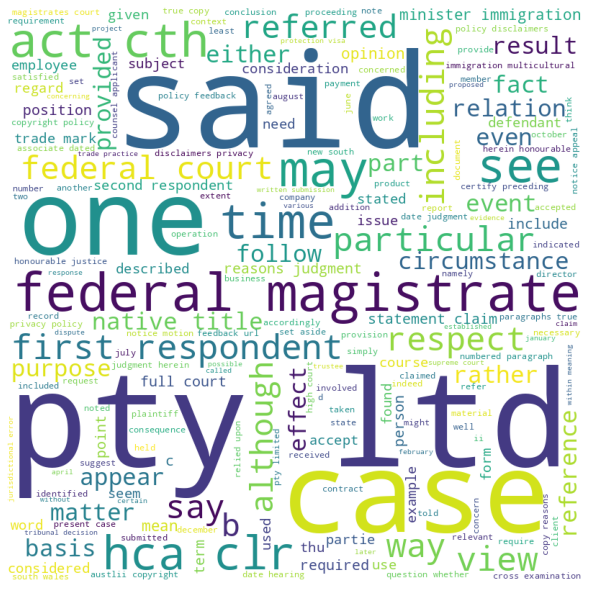

In [11]:
plot_wordcloud(documents)

As expected we have words like Federal, Magistrate, Respect, Respondent, Court in our wordcloud

## Insights:

<b><u>Insight 1:</u></b>

Our analysis is based on a corpus of 3890 documents, containing 725K sentences and 15.5M words. This voluminous dataset provides a comprehensive basis for our text analysis.

<b><u>Insight 2</u></b>:

Our text analysis reveals that the majority of cases have a positive tone.

We seems to distinguish atleast 2 types of cases based on the most common Bigram and Trigrams (Intelligent properties, Immigration)

if we had more times we would perform further analysis, such as comparing the polarities across different types of legal cases or examining the language and tone of specific legal documents, in order to gain a deeper understanding of the patterns and biases in the corpus.